<div style="text-align: left;"><h4>ФБ-24 Цадзікідзе Арсен</h4></div>
<h1><center>Лабораторна робота №7</center></h1>
<h3><center>З предмета "Засоби підготовки та аналізу даних"</center></h3>

In [20]:
import os
import shutil
import zipfile
import rasterio
import sklearn.metrics
import shapely.wkt
from sentinelhub import SHConfig
from rasterio.plot import show
import matplotlib
print("Setup Complete") # Setting up the coding environment

Setup Complete


<p><h4>Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки, назви яких відповідатимуть ідентифікаторам зображень</h4></p>

In [4]:
# Determine the paths to the necessary directories
lab7_directory = '/home/kali/Documents/lab7'
extracted_data_directory = os.path.join(lab7_directory, 'extracted_data')

# Check the existence of the folder
if os.path.exists(extracted_data_directory):
    user_input = input(f"Папка '{extracted_data_directory}' вже існує. Ви впевнені, що хочете розархівувати дані? Усі існуючі дані в цій папці будуть видалені (так/ні): ")
    if user_input.lower() == "так":
        shutil.rmtree(extracted_data_directory)
    else:
        print("Розархівування не потрібне, дані вже на місці.")
        exit()

os.makedirs(extracted_data_directory, exist_ok=True)

# Recursive extraction of archives
def unpack_archives(zip_path, destination):
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        zip_file.extractall(destination)
        for file in zip_file.namelist():
            if file.endswith('.zip'):
                nested_zip_path = os.path.join(destination, file)
                unpack_archives(nested_zip_path, destination)
                os.remove(nested_zip_path)

# Unzip all archives in the directory lab7_directory
for archive in os.listdir(lab7_directory):
    if archive.endswith('.zip'):
        archive_path = os.path.join(lab7_directory, archive)
        unpack_archives(archive_path, extracted_data_directory)

# Rename
for root_dir, sub_dirs, files in os.walk(extracted_data_directory):
    for directory in sub_dirs:
        if directory.startswith("S2A_MSIL2A"):
            if "T36UUA" in directory:
                new_directory_name = "sentinel_data_A"
            elif "T36UUB" in directory:
                new_directory_name = "sentinel_data_B"
            else:
                continue
            os.rename(os.path.join(root_dir, directory), os.path.join(root_dir, new_directory_name))

print("Усі архіви успішно розпаковані та перейменовані в папці 'extracted_data'.")

Усі архіви успішно розпаковані та перейменовані в папці 'extracted_data'.


<p><h4>Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл</h4></p>

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


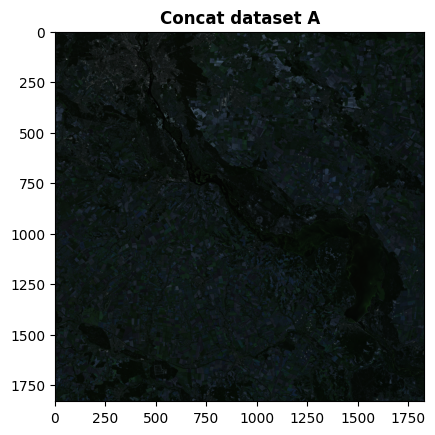

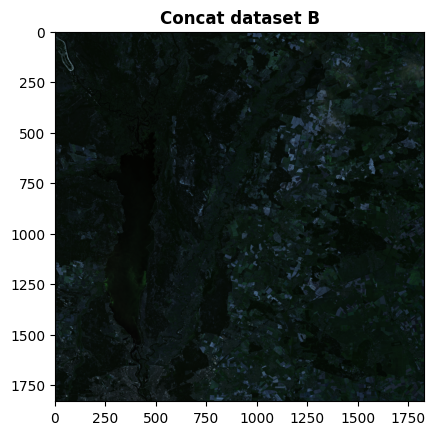

In [10]:
data_paths = {
    'A': {
        'B02': 'lab7/extracted_data/sentinel_data_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B02_60m.jp2',
        'B03': 'lab7/extracted_data/sentinel_data_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B03_60m.jp2',
        'B04': 'lab7/extracted_data/sentinel_data_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B04_60m.jp2',
        'B8A': 'lab7/extracted_data/sentinel_data_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B8A_60m.jp2'
    },
    'B': {
        'B02': 'lab7/extracted_data/sentinel_data_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B02_60m.jp2',
        'B03': 'lab7/extracted_data/sentinel_data_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B03_60m.jp2',
        'B04': 'lab7/extracted_data/sentinel_data_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B04_60m.jp2',
        'B8A': 'lab7/extracted_data/sentinel_data_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B8A_60m.jp2'
    }
}

# Dirs for output
output_dirs = ['sentinel_res/sentinel_A', 'sentinel_res/sentinel_B']
for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

# concatenation using gdal_merge.py
for dataset, paths in data_paths.items():
    output_file = f'sentinel_res/sentinel_{dataset}/concat{dataset}.tif'
    gdal_merge_cmd = f'gdal_merge.py -o {output_file} -separate {" ".join(paths.values())}'
    os.system(gdal_merge_cmd)

merged_datasets = {
    dataset: rasterio.open(f'sentinel_res/sentinel_{dataset}/concat{dataset}.tif')
    for dataset in ['A', 'B']
}

for dataset, raster in merged_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Concat dataset {dataset}')

<p><h4>Перепроектування супутникового зображення у проєкцію 4326</h4></p>

Processing sentinel_res/sentinel_A/concatA.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Processing sentinel_res/sentinel_B/concatB.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


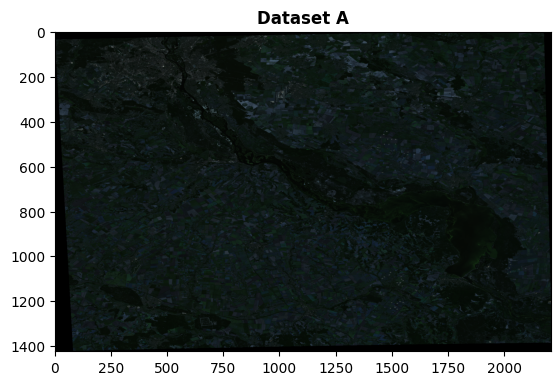

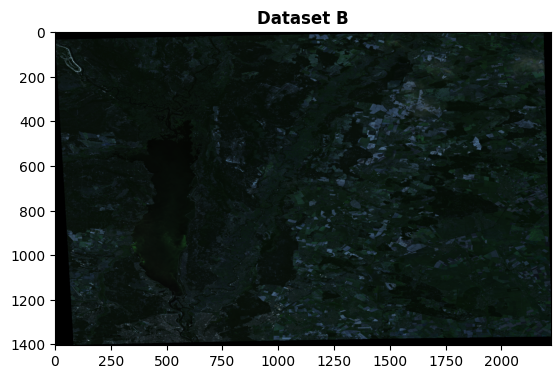

In [15]:
datasets = ['A', 'B']

for dataset in datasets:
    input_path = f'sentinel_res/sentinel_{dataset}/concat{dataset}.tif'
    output_path = f'sentinel_res/sentinel_{dataset}/pr{dataset}_4326.tif'
    gdalwarp_command = f'gdalwarp -t_srs EPSG:4326 {input_path} {output_path}'
    os.system(gdalwarp_command)

projected_files = {ds: rasterio.open(f'sentinel_res/sentinel_{ds}/pr{ds}_4326.tif') for ds in datasets}

for ds, raster in projected_files.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Dataset {ds}')

<p><h4>Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.</h4></p>

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


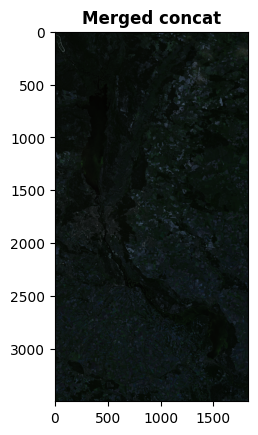

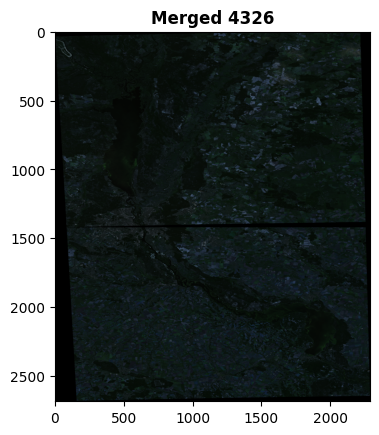

In [17]:
# optional concatenation of redesigned files with gdal_merge.py
gdal_merge_cmd = 'gdal_merge.py -o sentinel_res/sentinel_A/full_concat.tif sentinel_res/sentinel_A/concatA.tif sentinel_res/sentinel_B/concatB.tif'
os.system(gdal_merge_cmd)

gdal_merge_cmd = 'gdal_merge.py -o sentinel_res/sentinel_B/full_4326.tif sentinel_res/sentinel_A/prA_4326.tif sentinel_res/sentinel_B/prB_4326.tif'
os.system(gdal_merge_cmd)

merged_all = {
    'concat': rasterio.open('sentinel_res/sentinel_A/full_concat.tif'),
    '4326': rasterio.open('sentinel_res/sentinel_B/full_4326.tif')
}

for name, raster in merged_all.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Merged {name}')

<p><h4>Обрізання результуючого зображення по заданому векторному контуру</h4></p>

Creating output file that is 677P x 707L.
Processing sentinel_res/sentinel_A/full_concat.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 805P x 527L.
Processing sentinel_res/sentinel_B/full_4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


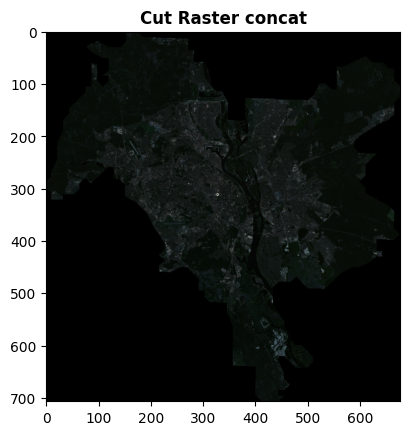

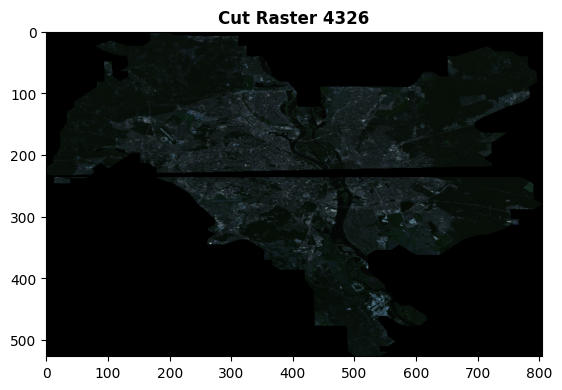

In [18]:
gdalwarp_cmd = 'gdalwarp -cutline lab7/Kyiv_regions.shp -crop_to_cutline sentinel_res/sentinel_A/full_concat.tif sentinel_res/cut_concat.tif'
os.system(gdalwarp_cmd)

gdalwarp_cmd = 'gdalwarp -cutline lab7/Kyiv_regions.shp -crop_to_cutline sentinel_res/sentinel_B/full_4326.tif sentinel_res/cut_4326.tif'
os.system(gdalwarp_cmd)

cut_all = {
    'concat': rasterio.open('sentinel_res/cut_concat.tif'),
    '4326': rasterio.open('sentinel_res/cut_4326.tif')
}

for name, raster in cut_all.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Cut Raster {name}')